# Solutions 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
sns.set(style='ticks', font_scale=1.3)
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

## Loading Data

First we'll load in the data that we'll be using. This includes things we've seen before, like the Penn World Tables, the Maddison Project data, and the World Bank Gini data. Additionally, we'll include the World Bank data on life expectancy, which can be downloaded here: [https://data.worldbank.org/indicator/SP.DYN.LE00.IN](https://data.worldbank.org/indicator/SP.DYN.LE00.IN). This data is provided in wide form (panel), so we'll also need to reshape it to long form.

In [4]:
# Penn World Tables (9.0)
pwt = pd.read_excel('data/pwt90.xlsx', sheet_name='Data')

In [5]:
# Maddison Project (2018)
mpd = pd.read_excel('data/mpd2018.xlsx', sheet_name='Full data')

In [6]:
# World Bank Gini - this is missing a lot of data, so we interpolate it as well
gini = pd.read_excel('data/world_bank_gini.xls')
gini_pan = gini.pivot('year', 'countrycode')['gini']
gini_pan = gini_pan.interpolate(limit_direction='both')
gini_int = gini_pan.reset_index().melt('year', value_name='gini')

In [7]:
# World Bank Life Expectancy - this data comes in a weird format, so we need to work it a little
life = pd.read_excel('data/world_bank_life.xls', sheet_name='Data', skiprows=3) # load data, skipping first 3 rows
life = life.drop(['Country Name', 'Indicator Name', 'Indicator Code'], axis=1) # drop unneeded columns
life = life.melt('Country Code', var_name='Year', value_name='life_exp') # reshape from wide to long form
life = life.rename({'Country Code': 'countrycode', 'Year': 'year'}, axis=1) # make column names consistent
life['year'] = life['year'].astype(np.int) # make sure the year is an integer, not a string
life = life.dropna() # drop missing values

## Problem 1(a)

Let's calculate population growth and log GDP per capita and investigate their relationship.

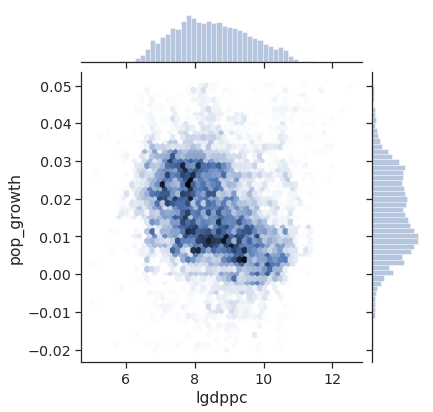

In [8]:
mpd1 = mpd.copy() # make a copy of the original data
mpd1['pop_growth'] = np.log(mpd1['pop']).diff() # calculate population growth
mpd1['lgdppc'] = np.log(mpd1['rgdpnapc']) # calculate log gdp per capita
mpd1 = mpd1.query('pop_growth > -0.02 and pop_growth < 0.05'); # drop extremely population changes
sns.jointplot('lgdppc', 'pop_growth', kind='hex', data=mpd1); # plot relationship

Here we can see a clear negative correlation. Is this causal? We can't be sure looking just at this, but this is consistent with the conventional wisdom that rich countries have low birth rates (as well as low death rates, but not enough to reverse the trend). So our Malthusian assumption that population growth rises with the standard of living doesn't hold. This is fine though, since the Malthusian is meant to describe societies from a much earlier era of 

**Technical Note**: The way we calculate population growth isn't 100% correct since we use long-form data. But it's good enought for our purposes and produces a nearly identical graph  to the one above. The totally valid approach would look like:

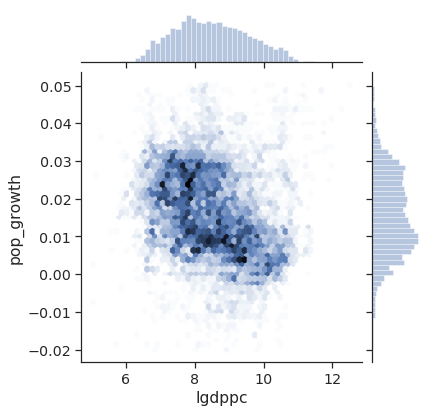

In [9]:
mpd_pan = mpd.pivot('year', 'countrycode') # pivot to wide form (year x countrycode)
pop_growth = np.log(mpd_pan['pop']).diff() # calculate yearly differences in logs (growth rate)
pop_growth = pop_growth.reset_index().melt('year', value_name='pop_growth') # unpivot back to long form
mpd1 = mpd.merge(pop_growth, on=['year', 'countrycode']) # join in with original mpd data
mpd1['lgdppc'] = np.log(mpd1['rgdpnapc']) # calculate log gdp per capita
mpd1 = mpd1.query('pop_growth > -0.02 and pop_growth < 0.05'); # drop extremely population changes
sns.jointplot('lgdppc', 'pop_growth', kind='hex', data=mpd1); # plot relationship

## Problem 1(b)

The PWT actually provides a pre-calculated labor share variable (`labsh`) that we can use. First, let's look at the labor share trend in the US.

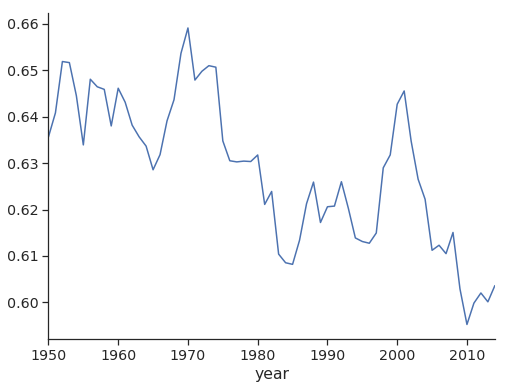

In [10]:
pwt_pan = pwt.pivot('year', 'countrycode')
pwt_pan['labsh']['USA'].plot();

This isn't moving around too much. There is a slow but volatile decline from around 65% in 1950 to 60% today. One suscpects this may be related to the decline in unionization in the US. Now let's look at some other countries

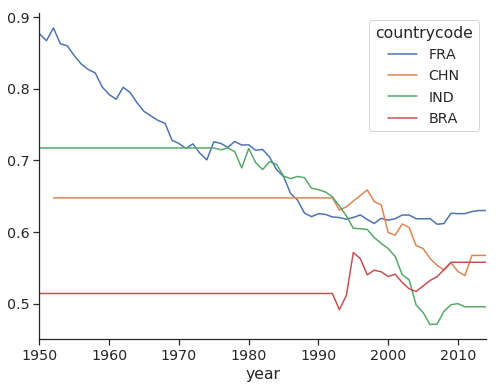

In [11]:
pwt_pan['labsh'][['FRA', 'CHN', 'IND', 'BRA']].plot();

Here things are much more interesting. In France and India, we see precipitous declines, with the 1950 value for France being near an amazing 90%. Meanwhile, the current value for India is below 50%. The story of China looks a bit more similar to that of the US, and Brazil actually sees a slight increase since the early 1990's.

## Problem 1(c)

For this we need to join the PWT and the World Bank Gini data. Then we'll calculate a variable that measures trade exposure. Here, I'll use the ratio of total trade (imports + exports) to GDP. These come from the share of exports `csh_x` and the share of imports `csh_m`.

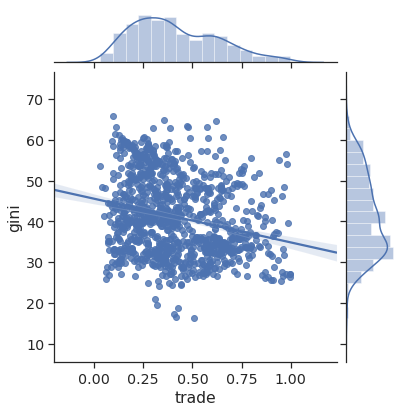

In [12]:
pwt1 = pwt.merge(gini, on=['year', 'countrycode'], how='left')
pwt1['trade'] = pwt1['csh_x'] - pwt['csh_m'] # note that csh_m is negative so we subtract it
pwt1['lgdppc'] = np.log(pwt1['rgdpna']/pwt1['pop'])
pwt1 = pwt1.query('trade > 0 and trade < 1') # eliminate huge outliers
sns.jointplot('trade', 'gini', kind='reg', data=pwt1);

It's pretty noisy, but it looks like there's a negative correlation. Time to think about causation! Remember those causal networks! There could be some common factor that's driving both of these.

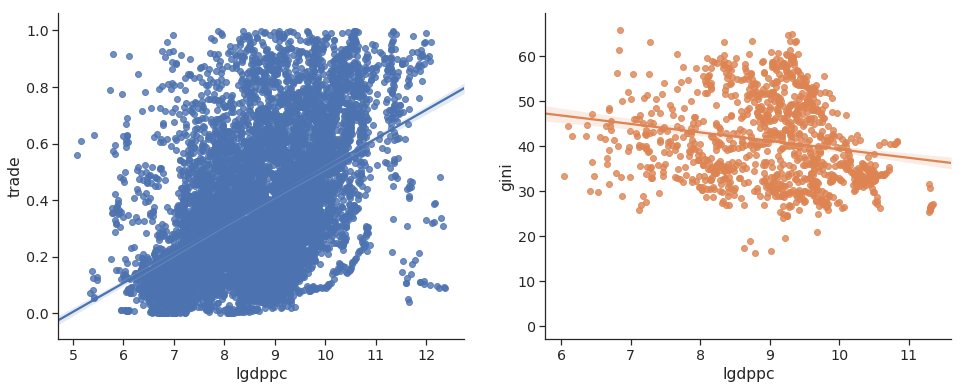

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))
sns.regplot('lgdppc', 'trade', data=pwt1, ax=ax1);
sns.regplot('lgdppc', 'gini', data=pwt1, ax=ax2);

So here we can see that one plausible story is simply that richer countries more (positive correlation on left plot) and also richer countries have lower inquality (negative correlation on right plot). But we can't really be sure of the direction of causality between these three variables from this data alone. The other interseting trend is that it's actually different if we look before 2000 vs after 2000. Perhaps the nature of trade was different during these two periods?

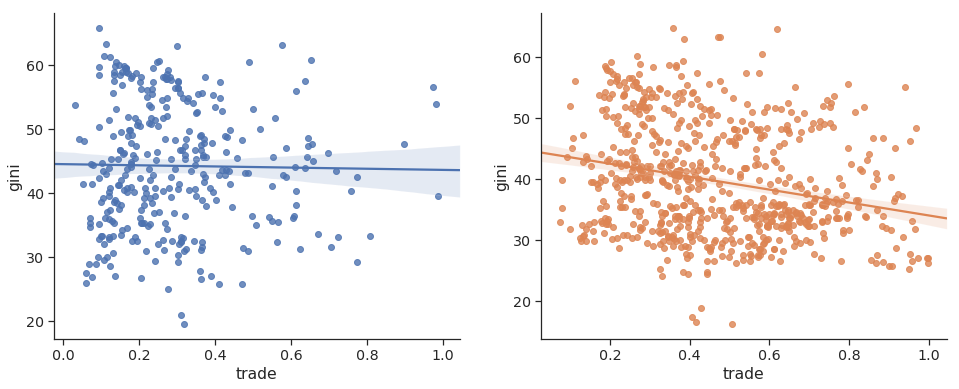

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))
sns.regplot('trade', 'gini', data=pwt1.query('year <= 2000'), ax=ax1);
sns.regplot('trade', 'gini', data=pwt1.query('year > 2000'), ax=ax2);

Finally, one way to think about all of these factors at once is to use a regression. Here it seems that both higher income and higher exports reduce inequality, while higher imports are associated with more inquality.

In [15]:
import statsmodels.formula.api as smf # import stats library
ret = smf.ols('gini ~ 1 + lgdppc + csh_x + csh_m', data=pwt1).fit() # run the regression
ret.params # this prints out the regression coefficients

Intercept    53.878857
lgdppc       -1.023722
csh_x        -5.985043
csh_m        10.360693
dtype: float64

## Problem 2(a)

First, we have a bunch of parameters that are important

In [16]:
ubar = 5 # value of life, yearly
eps = 1 # elasticity of labor disutility
theta = 14.2 # magnitude of labor disutility
max_work = 50*5*16 # max possible working hours per year
v = lambda ell: -(theta*eps)/(1+eps)*(1-ell)**((1+eps)/eps) # leisure utility function (labor disutility)

Here we need to merge PWT with both the World Bank Gini data and the World Bank life expentancy data. Some of the series, in particular the Gini data is missing many data points. So let's interpolate those

In [17]:
pwt1 = pwt.merge(gini_int, on=['year', 'countrycode'], how='left')
pwt1 = pwt1.merge(life, on=['year', 'countrycode'], how='left')

Now we construct some statistics such as GDP per capita, leisure time, and income variance

In [18]:
pwt1['conpc'] = pwt1['rconna']/pwt1['pop']
usa2000 = pwt1.query('countrycode == "USA" and year == 2000').iloc[0]
pwt1['cons'] = pwt1['conpc']/usa2000['conpc'] # we treat USA 2000 GDP as our units
pwt1['leisure'] = 1 - pwt1['avh']/max_work
pwt1['sigma'] = np.sqrt(2)*scipy.stats.norm.ppf((1+pwt1['gini']/100)/2)

Calculate the per period utility from the various sources

In [19]:
pwt1['util_cons'] = np.log(pwt1['cons'])
pwt1['util_leis'] = v(pwt1['leisure'])
pwt1['util_ineq'] = -0.5*pwt1['sigma']**2
pwt1['util'] = ubar + pwt1['util_cons'] + pwt1['util_leis'] + pwt1['util_ineq']
usa2000 = pwt1.query('countrycode == "USA" and year == 2000').iloc[0]

Now we'll calculate the contribution to welfare of our four factors: average GDP, leisure, inequality, and life expectancy. This uses the simple utility equation from Jones

In [20]:
pwt1['life_prop'] = pwt1['life_exp']/usa2000['life_exp'] - 1
pwt1['llambda_life'] = pwt1['life_prop']*pwt1['util']
pwt1['llambda_cons'] = pwt1['util_cons'] - usa2000['util_cons']
pwt1['llambda_leis'] = pwt1['util_leis'] - usa2000['util_leis']
pwt1['llambda_ineq'] = pwt1['util_ineq'] - usa2000['util_ineq']
pwt1['llambda'] = pwt1['llambda_life'] + pwt1['llambda_cons'] + pwt1['llambda_leis'] + pwt1['llambda_ineq']

We'll often be interested in the real value of $\lambda$ rather than its log.

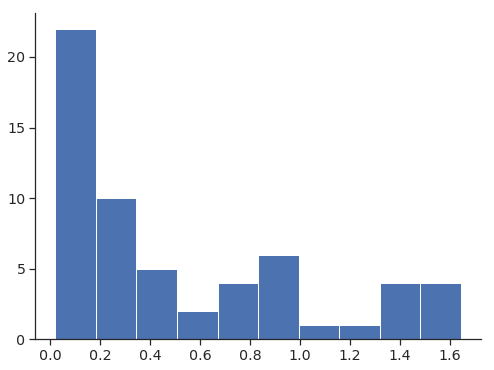

In [21]:
pwt1['lambda_life'] = np.exp(pwt1['llambda_life'])
pwt1['lambda_cons'] = np.exp(pwt1['llambda_cons'])
pwt1['lambda_leis'] = np.exp(pwt1['llambda_leis'])
pwt1['lambda_ineq'] = np.exp(pwt1['llambda_ineq'])
pwt1['lambda'] = np.exp(pwt1['llambda'])
pwt1.query('year == 2000')['lambda'].hist(grid=False);

One issue with the first way that Jones does things is that life is valued differentially across countries, which seems odd. We can 

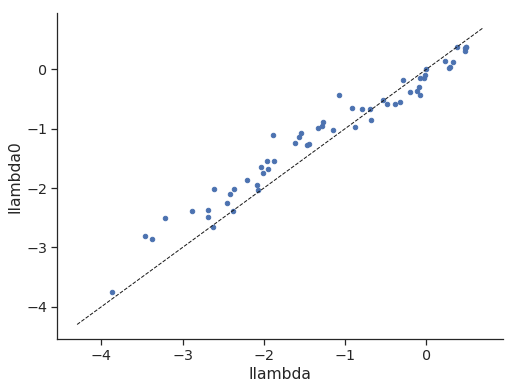

In [22]:
pwt1['life_prop0'] = usa2000['life_exp']/pwt1['life_exp'] - 1
pwt1['llambda_life0'] = pwt1['life_prop0']*usa2000['util']
pwt1['llambda0'] = pwt1['llambda_life0'] + pwt1['llambda_cons'] + pwt1['llambda_leis'] + pwt1['llambda_ineq']
pwt1['lambda0'] = np.exp(pwt1['llambda0'])
ax = pwt1.query('year == 2000').plot.scatter('llambda', 'llambda0', c='b');
ax.plot([-4.3,0.7], [-4.3,0.7], c='k', linestyle='--', linewidth=1);

## Problem 2(b)

Here I decided to plot four countries. I included Korea and the Philippines because they had similar GDP levels in 1950, but later diverged. Brazil and Turkey had a similar starting point but diverged quite a bit less.

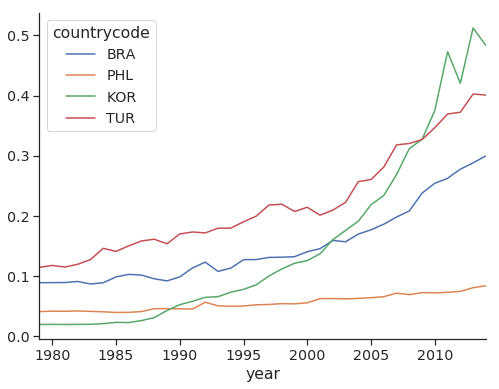

In [23]:
pwt1_pan = pwt1.pivot('year', 'countrycode')
pwt1_pan['lambda'][['BRA', 'PHL', 'KOR', 'TUR']].dropna().plot();

It's interesting to consider some of the costs of the growth that these contries have seen. In particular, one might worry that increase in consumption come at the cost of leisure time. Below we can see that Korea and Brazil have actually seen simultaneous rises in leisure.

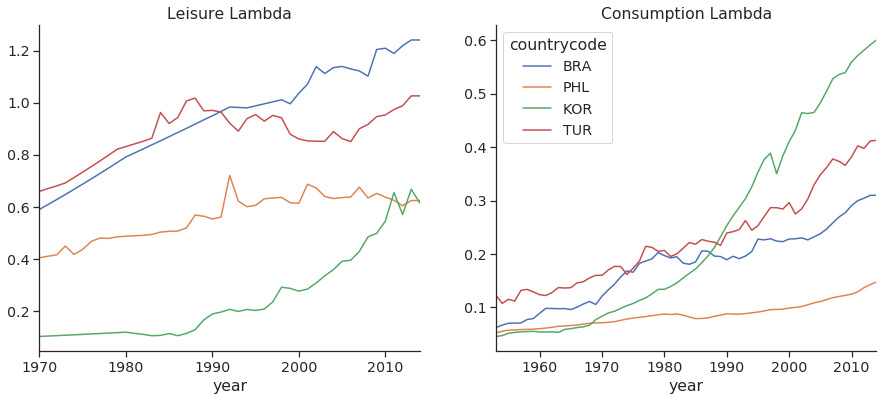

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))
np.exp(pwt1_pan['llambda_leis'][['BRA', 'PHL', 'KOR', 'TUR']]).dropna().plot(ax=ax1, legend=False);
np.exp(pwt1_pan['llambda_cons'][['BRA', 'PHL', 'KOR', 'TUR']]).dropna().plot(ax=ax2);
ax1.set_title('Leisure Lambda');
ax2.set_title('Consumption Lambda');

## Problem 2(c)

Here we might consider an macroeconomic variable like the unemployment rate. Once again, the World Bank comes to the rescue and provides some cross-country data here.

How can we model unemployment in the utility? Essentially, as a random even where one sometimes gets lower income. Of course, you don't starve if you're unemployed. Many countries have insurance wherein one is given a certain fraction of their previous income instead. This varies from country to country, but lets say its about $b=50\%$ in most places. In order to still have the same average consumption, we need employed people to make a bit more ($b^{\prime}$), so that

$$ c = p b c + (1-p) b^{\prime} c \quad \Rightarrow \quad b^{\prime} = \frac{1-pb}{1-p} $$

With this we can write down the consumption component of the utility function, where $p$ is the unemployment rate and $b$ is the replacement rate

$$ u(c, p, b) = p \log(b c) + (1-p) \log(b^{\prime} c) = \log(c) + p \log(b) + (1-p) \log(b^{\prime}) $$

So it's actually relatively simple, we just have an additional term that is a function of the unemployment rate $p$. First, let's load in the World Bank unemployment rate data.

In [25]:
# this data comes in a weird format, so we need to work it a little
unemp = pd.read_excel('data/world_bank_unemp.xls', sheet_name='Data', skiprows=3) # load data, skipping first 3 rows
unemp = unemp.drop(['Country Name', 'Indicator Name', 'Indicator Code'], axis=1) # drop unneeded columns
unemp = unemp.melt('Country Code', var_name='Year', value_name='unemp') # reshape from wide to long form
unemp = unemp.rename({'Country Code': 'countrycode', 'Year': 'year'}, axis=1) # make column names consistent
unemp['year'] = unemp['year'].astype(np.int) # make sure the year is an integer, not a string
unemp = unemp.dropna() # drop missing values

Now we just need to incorporate this into our original analysis

In [26]:
b = 0.5 # replacement rate
pwt2 = pwt1.merge(unemp, on=['countrycode', 'year'], how='left')
pwt2['unemp'] = pwt2['unemp']/100 # gotta divide by 100!
pwt2['bprime'] = (1-pwt2['unemp']*b)/(1-pwt2['unemp'])
pwt2['util_unemp'] = pwt2['unemp']*np.log(b) + (1-pwt2['unemp'])*np.log(pwt2['bprime'])
usa2000u = pwt2.query('countrycode == "USA" and year == 2000').iloc[0]
pwt2['llambda_unemp'] = pwt2['util_unemp'] - usa2000u['util_unemp']
pwt2['llambda'] = pwt2['llambda_life'] + pwt2['llambda_cons'] + pwt2['llambda_unemp'] + pwt2['llambda_leis'] + pwt2['llambda_ineq']

Let's revisit the original set of countries we looked at. We can see that the ordering is not affected too much over time, but both Brazil and Turkey take bigger hits from unemployment. On the order of 1%.

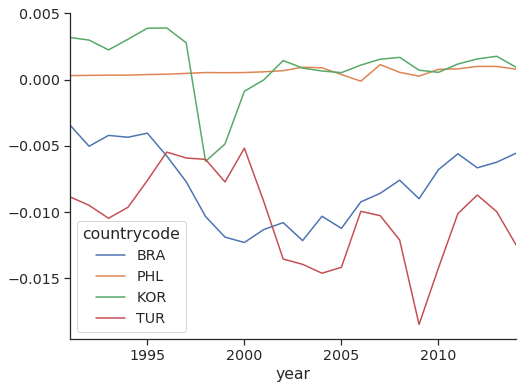

In [27]:
pwt2_pan = pwt2.pivot('year', 'countrycode')
pwt2_pan['llambda_unemp'][['BRA', 'PHL', 'KOR', 'TUR']].dropna().plot();

We can also look at the distribution of unemployment losses (this is absolute, not relative to the US). There are substantial and can reach up to 10%.

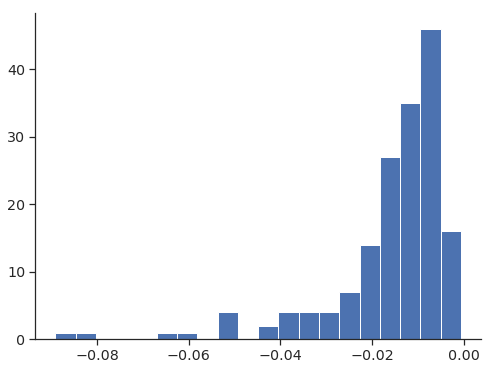

In [28]:
pwt2.query('year == 2008')['util_unemp'].hist(grid=False, bins=20);